In [1]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import numpy as np
from termcolor import colored
from torch._C import dtype
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'SA'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [6]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556


# **MLP MODEL**

In [7]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model_MLP = MLP(hidden_channels=16)
print(model_MLP)


MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
model_MLP = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model_MLP.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model_MLP(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model_MLP.eval()
      out = model_MLP(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9609
Epoch: 002, Loss: 1.9558
Epoch: 003, Loss: 1.9485
Epoch: 004, Loss: 1.9413
Epoch: 005, Loss: 1.9297
Epoch: 006, Loss: 1.9266
Epoch: 007, Loss: 1.9124
Epoch: 008, Loss: 1.9024
Epoch: 009, Loss: 1.8985
Epoch: 010, Loss: 1.8849
Epoch: 011, Loss: 1.8753
Epoch: 012, Loss: 1.8684
Epoch: 013, Loss: 1.8483
Epoch: 014, Loss: 1.8465
Epoch: 015, Loss: 1.8115
Epoch: 016, Loss: 1.8143
Epoch: 017, Loss: 1.7900
Epoch: 018, Loss: 1.7985
Epoch: 019, Loss: 1.7639
Epoch: 020, Loss: 1.7383
Epoch: 021, Loss: 1.7229
Epoch: 022, Loss: 1.7452
Epoch: 023, Loss: 1.7000
Epoch: 024, Loss: 1.6855
Epoch: 025, Loss: 1.6691
Epoch: 026, Loss: 1.6479
Epoch: 027, Loss: 1.6284
Epoch: 028, Loss: 1.5960
Epoch: 029, Loss: 1.5562
Epoch: 030, Loss: 1.5396
Epoch: 031, Loss: 1.5488
Epoch: 032, Loss: 1.5224
Epoch: 033, Loss: 1.4665
Epoch: 034, Loss: 1.4885
Epoch: 035, Loss: 1.4399
Epoch: 036, Loss: 1.4035
Epoch: 037, Loss: 1.4265
Epoch: 038, Loss: 1.3742
Epoch: 039, Loss: 1.3742
Epoch: 040, Loss: 1.3391


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5740


# **GCN MODEL**

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

SA_model_GCN = GCN(hidden_channels=16)
print(SA_model_GCN)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


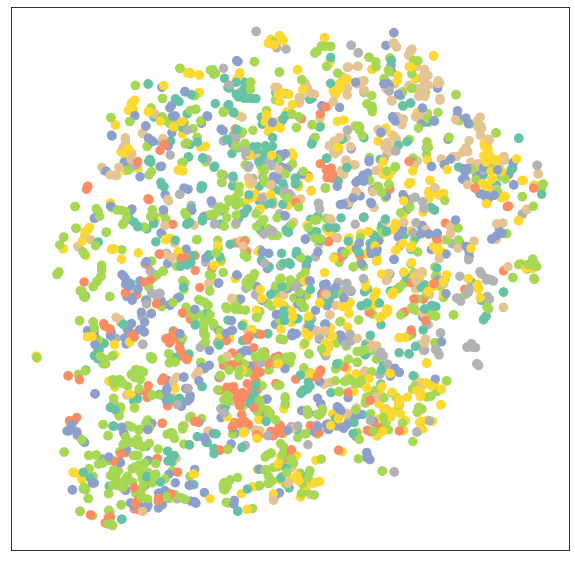

In [ ]:
SA_model_GCN = GCN(hidden_channels=16)
SA_model_GCN.eval()

out = SA_model_GCN(data.x, data.edge_index)
visualize(out, color=data.y)


In [ ]:
SA_optimizer = torch.optim.Adam(SA_model_GCN.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [ ]:
def loading_model(load_index):
  SA_model_GCN = GCN(hidden_channels=16)
  SA_optimizer = torch.optim.Adam(params = SA_model_GCN.parameters(), lr=1e-4)
  checkpoint = torch.load("/content/drive/My Drive/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  SA_model_GCN.load_state_dict(checkpoint['model_state_dict'])
  SA_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return SA_model_GCN, SA_optimizer, epoch

In [ ]:
def visualize_losses(g_losses, epoch_history):
  g_losses_list = torch.stack(g_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("SA Model Loss in Epoch: " + str(epoch_history))
  ax.plot(g_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [ ]:
def train_step():
  SA_model_GCN.train(True)

  SA_optimizer.zero_grad()  
  SA_out_GCN = SA_model_GCN(data.x, data.edge_index)  

  SA_loss = loss_calculations(SA_out_GCN[data.train_mask], data.y[data.train_mask])  
  SA_loss.backward(retain_graph=True)

  SA_optimizer.step()    


  return SA_loss


In [ ]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  SA_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    SA_model_training_loss= train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {SA_model_training_loss:.4f}')

    SA_training_loss_per_epoch.append(SA_model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(SA_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': SA_model_GCN.state_dict(), 'optimizer_state_dict': SA_optimizer.state_dict(), 'loss': SA_training_loss_per_epoch,}, "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss




# **Test Configuration for the Model**

In [ ]:
def SA_test():
  SA_model_GCN.eval()
  SA_out = SA_model_GCN(data.x, data.edge_index)
  SA_pred = SA_out.argmax(dim=1) 
  SA_test_correct = SA_pred[data.test_mask] == data.y[data.test_mask] 
  SA_test_acc = int(SA_test_correct.sum()) / int(data.test_mask.sum())
  return SA_test_acc

Epoch: 001, SA Model Loss: 1.9465
Epoch: 002, SA Model Loss: 1.9419
Epoch: 003, SA Model Loss: 1.9363
Epoch: 004, SA Model Loss: 1.9290
Epoch: 005, SA Model Loss: 1.9199
Epoch: 006, SA Model Loss: 1.9140
Epoch: 007, SA Model Loss: 1.9079
Epoch: 008, SA Model Loss: 1.8992
Epoch: 009, SA Model Loss: 1.8876
Epoch: 010, SA Model Loss: 1.8764
Epoch: 011, SA Model Loss: 1.8656
Epoch: 012, SA Model Loss: 1.8626
Epoch: 013, SA Model Loss: 1.8460
Epoch: 014, SA Model Loss: 1.8329
Epoch: 015, SA Model Loss: 1.8225
Epoch: 016, SA Model Loss: 1.8167
Epoch: 017, SA Model Loss: 1.7995
Epoch: 018, SA Model Loss: 1.7878
Epoch: 019, SA Model Loss: 1.7716
Epoch: 020, SA Model Loss: 1.7568
Epoch: 021, SA Model Loss: 1.7563
Epoch: 022, SA Model Loss: 1.7342
Epoch: 023, SA Model Loss: 1.7092
Epoch: 024, SA Model Loss: 1.7015
Epoch: 025, SA Model Loss: 1.6671
Epoch: 026, SA Model Loss: 1.6757
Epoch: 027, SA Model Loss: 1.6609
Epoch: 028, SA Model Loss: 1.6355
Epoch: 029, SA Model Loss: 1.6339
Epoch: 030, SA

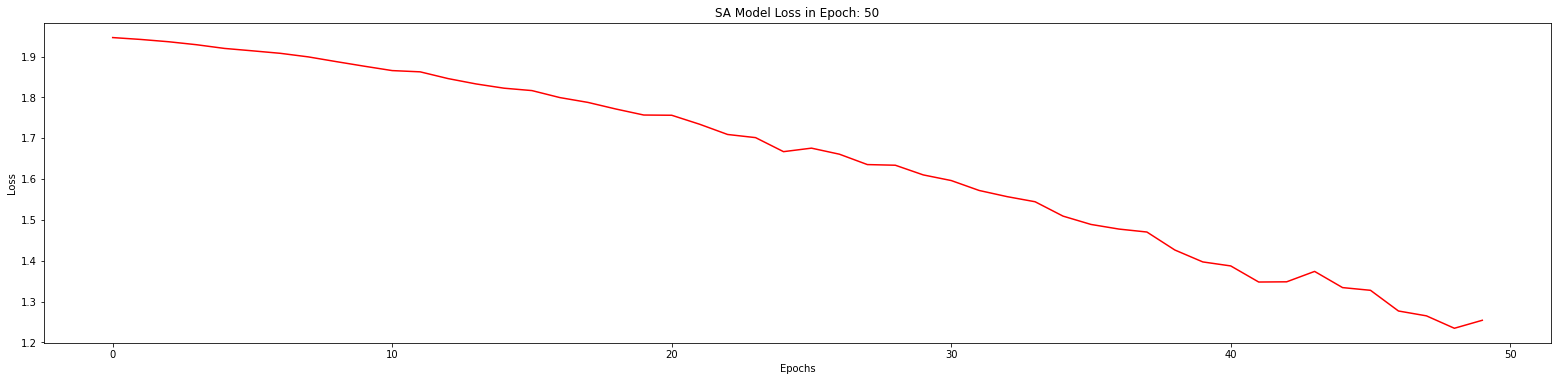

Epoch: 051, SA Model Loss: 1.1622
Epoch: 052, SA Model Loss: 1.1483
Epoch: 053, SA Model Loss: 1.1535
Epoch: 054, SA Model Loss: 1.1912
Epoch: 055, SA Model Loss: 1.0880
Epoch: 056, SA Model Loss: 1.1374
Epoch: 057, SA Model Loss: 1.0657
Epoch: 058, SA Model Loss: 1.0748
Epoch: 059, SA Model Loss: 1.0654
Epoch: 060, SA Model Loss: 1.0201
Epoch: 061, SA Model Loss: 0.9967
Epoch: 062, SA Model Loss: 1.0499
Epoch: 063, SA Model Loss: 1.0116
Epoch: 064, SA Model Loss: 0.9945
Epoch: 065, SA Model Loss: 0.9499
Epoch: 066, SA Model Loss: 0.9465
Epoch: 067, SA Model Loss: 0.9633
Epoch: 068, SA Model Loss: 0.9137
Epoch: 069, SA Model Loss: 0.9168
Epoch: 070, SA Model Loss: 0.8818
Epoch: 071, SA Model Loss: 0.8984
Epoch: 072, SA Model Loss: 0.8301
Epoch: 073, SA Model Loss: 0.8664
Epoch: 074, SA Model Loss: 0.8560
Epoch: 075, SA Model Loss: 0.8457
Epoch: 076, SA Model Loss: 0.8306
Epoch: 077, SA Model Loss: 0.8333
Epoch: 078, SA Model Loss: 0.8155
Epoch: 079, SA Model Loss: 0.7878
Epoch: 080, SA

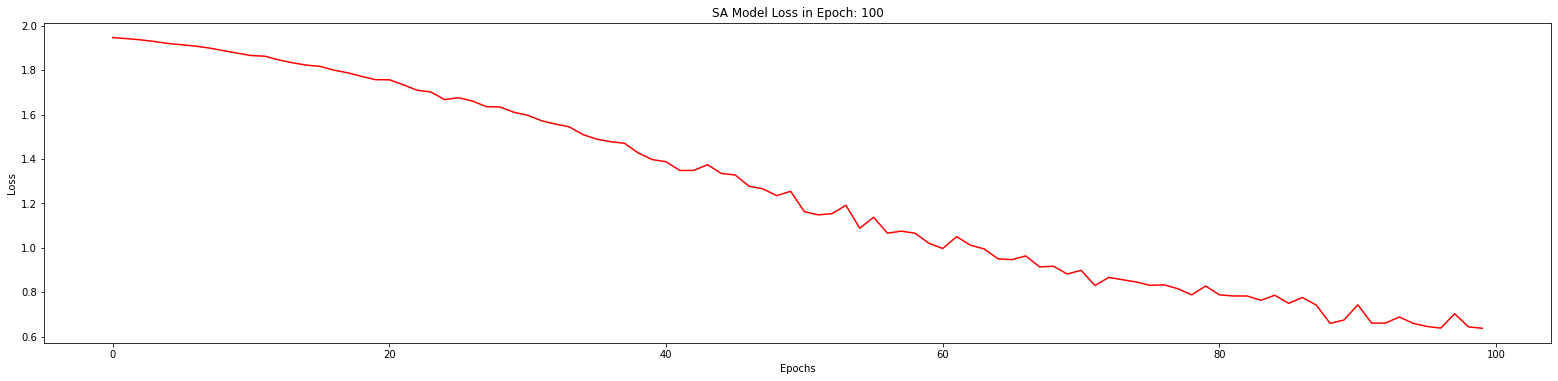

Epoch: 101, SA Model Loss: 0.6198
Epoch: 102, SA Model Loss: 0.6352
Epoch: 103, SA Model Loss: 0.6056
Epoch: 104, SA Model Loss: 0.6586
Epoch: 105, SA Model Loss: 0.5941
Epoch: 106, SA Model Loss: 0.5978
Epoch: 107, SA Model Loss: 0.5879
Epoch: 108, SA Model Loss: 0.6061
Epoch: 109, SA Model Loss: 0.6011
Epoch: 110, SA Model Loss: 0.5905
Epoch: 111, SA Model Loss: 0.6000
Epoch: 112, SA Model Loss: 0.5716
Epoch: 113, SA Model Loss: 0.5795
Epoch: 114, SA Model Loss: 0.5234
Epoch: 115, SA Model Loss: 0.5814
Epoch: 116, SA Model Loss: 0.5577
Epoch: 117, SA Model Loss: 0.5548
Epoch: 118, SA Model Loss: 0.5346
Epoch: 119, SA Model Loss: 0.5264
Epoch: 120, SA Model Loss: 0.5309
Epoch: 121, SA Model Loss: 0.5272
Epoch: 122, SA Model Loss: 0.5731
Epoch: 123, SA Model Loss: 0.5770
Epoch: 124, SA Model Loss: 0.5377
Epoch: 125, SA Model Loss: 0.5387
Epoch: 126, SA Model Loss: 0.5304
Epoch: 127, SA Model Loss: 0.5059
Epoch: 128, SA Model Loss: 0.5701
Epoch: 129, SA Model Loss: 0.4976
Epoch: 130, SA

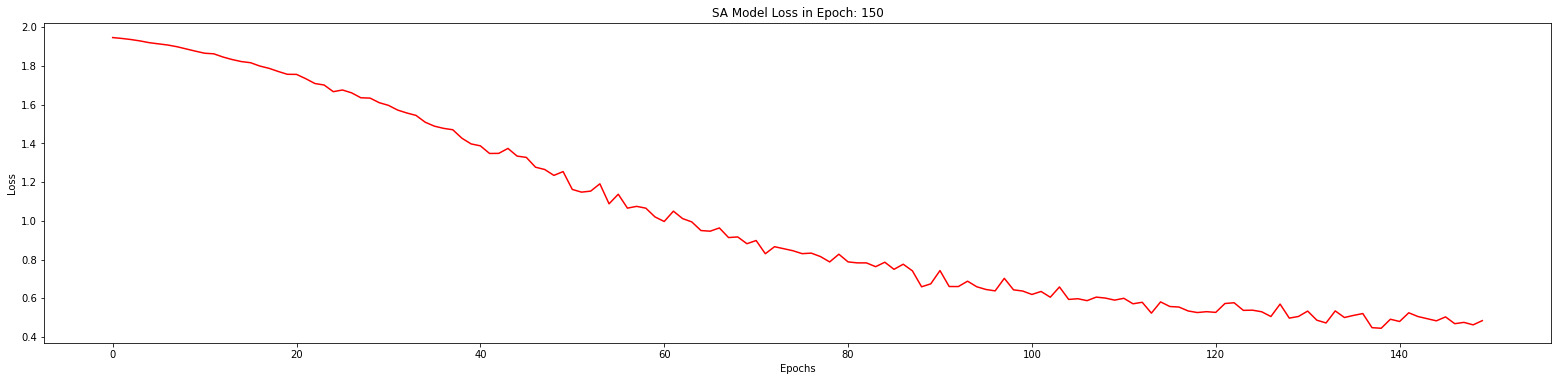

Epoch: 151, SA Model Loss: 0.4449
Epoch: 152, SA Model Loss: 0.4446
Epoch: 153, SA Model Loss: 0.4399
Epoch: 154, SA Model Loss: 0.4607
Epoch: 155, SA Model Loss: 0.4422
Epoch: 156, SA Model Loss: 0.4418
Epoch: 157, SA Model Loss: 0.4236
Epoch: 158, SA Model Loss: 0.4378
Epoch: 159, SA Model Loss: 0.4547
Epoch: 160, SA Model Loss: 0.4715
Epoch: 161, SA Model Loss: 0.3867
Epoch: 162, SA Model Loss: 0.3970
Epoch: 163, SA Model Loss: 0.4133
Epoch: 164, SA Model Loss: 0.4163
Epoch: 165, SA Model Loss: 0.4722
Epoch: 166, SA Model Loss: 0.4054
Epoch: 167, SA Model Loss: 0.3936
Epoch: 168, SA Model Loss: 0.4379
Epoch: 169, SA Model Loss: 0.4033
Epoch: 170, SA Model Loss: 0.3718
Epoch: 171, SA Model Loss: 0.3857
Epoch: 172, SA Model Loss: 0.3929
Epoch: 173, SA Model Loss: 0.4014
Epoch: 174, SA Model Loss: 0.4482
Epoch: 175, SA Model Loss: 0.4185
Epoch: 176, SA Model Loss: 0.4107
Epoch: 177, SA Model Loss: 0.3904
Epoch: 178, SA Model Loss: 0.4145
Epoch: 179, SA Model Loss: 0.3785
Epoch: 180, SA

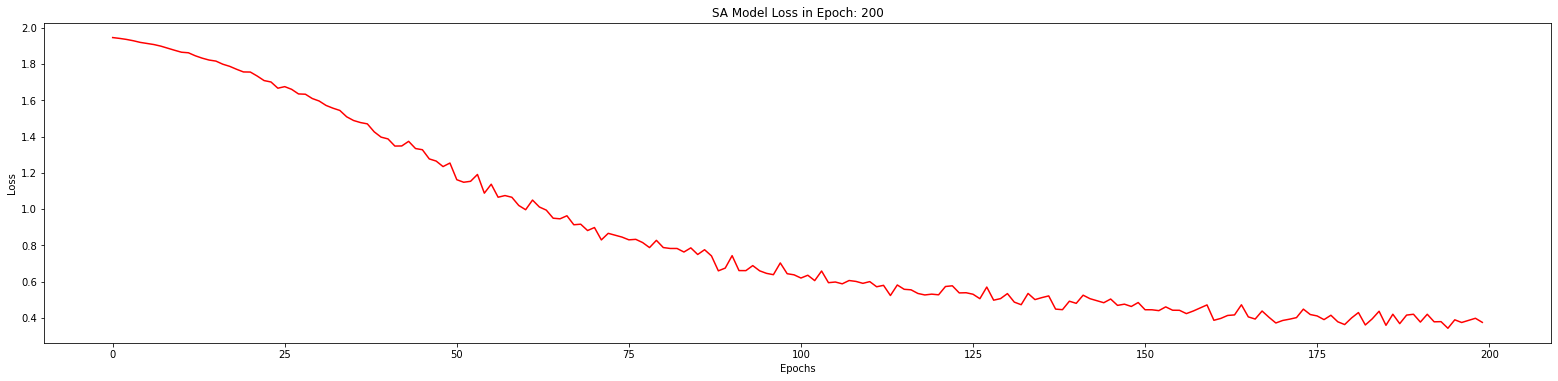

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

In [ ]:
SA_test_acc = SA_test()
print(f'Test Accuracy: {SA_test_acc:.4f}')

Test Accuracy: 0.8140


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


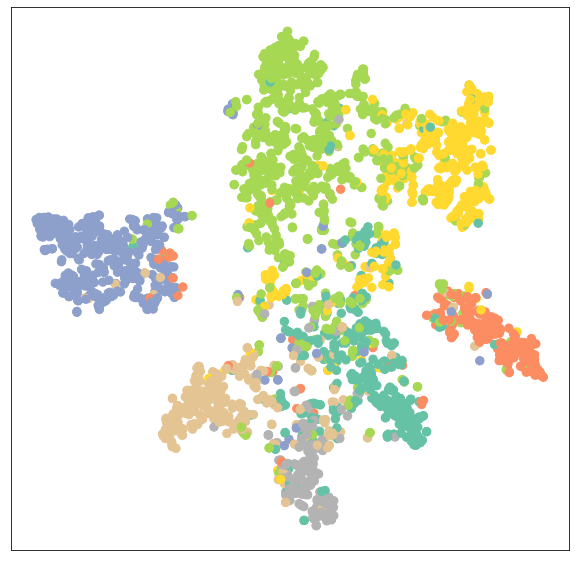

In [ ]:
SA_model_GCN.eval()

SA_test_out = SA_model_GCN(data.x, data.edge_index)
visualize(SA_test_out, color=data.y)

# **Gradients of SA**


In [ ]:
def accumulate_gradients(model_for_you):
  before_SA = []
  after_SA = []
  
  for name, param in model_for_you.named_parameters():
    if name == "conv1.bias":
      before_SA.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_SA.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_SA.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_SA.append(param.grad.detach().clone())
    if name == "conv2.bias":
      before_SA.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_SA.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_SA.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_SA.append(param.grad.detach().clone())
  

  return before_SA, after_SA

In [ ]:
holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(SA_model_GCN)

In [ ]:
print(len(holder_of_new_gradients))

4


# **SA**
# **Based on the Training Phase, for each of the Hidden Nodes in the First and Second Layers, which Gradient is more important?**

In [ ]:
def SA_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, epoch): 
  layer = 1
  for i in range(len(holder_of_new_gradients[layer])):

    fig1 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer][i], color='r')
    ax2.plot(holder_of_old_gradients[layer][i], color='r')

    plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
  layer = 2
  for i in range(len(holder_of_new_gradients[layer+1])):
    fig2 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("SA Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+1][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+1][i], color='r')

    plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
    


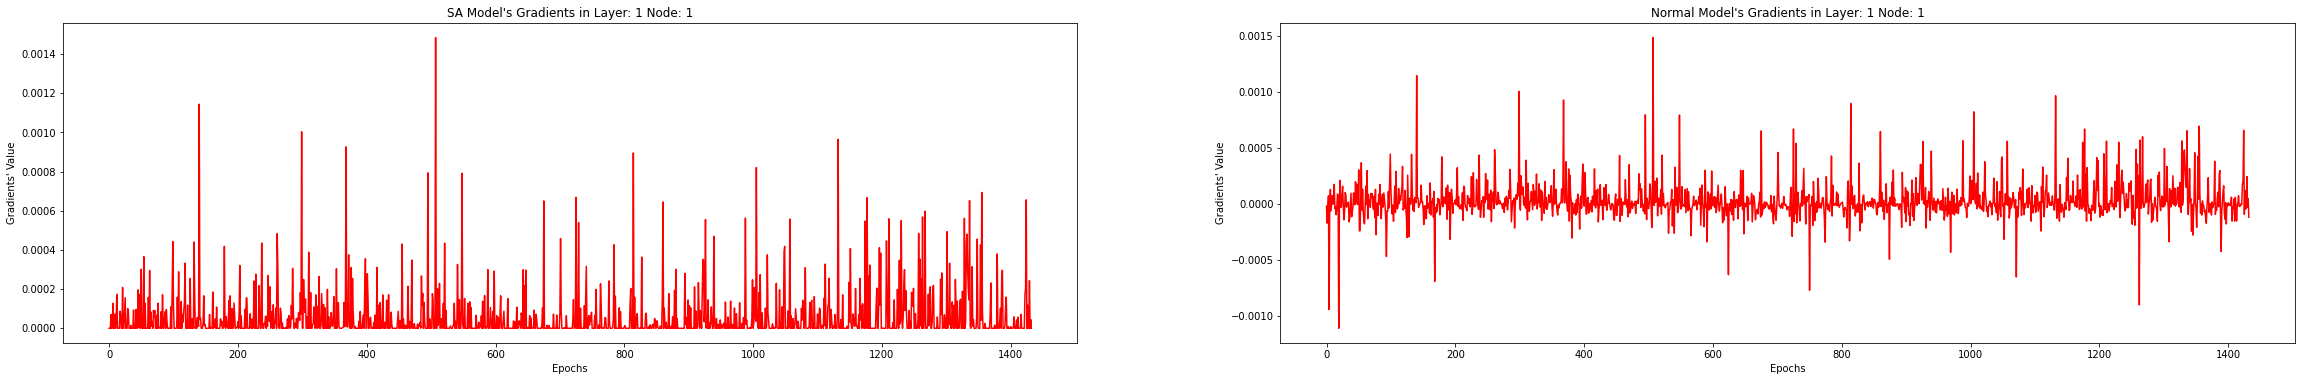

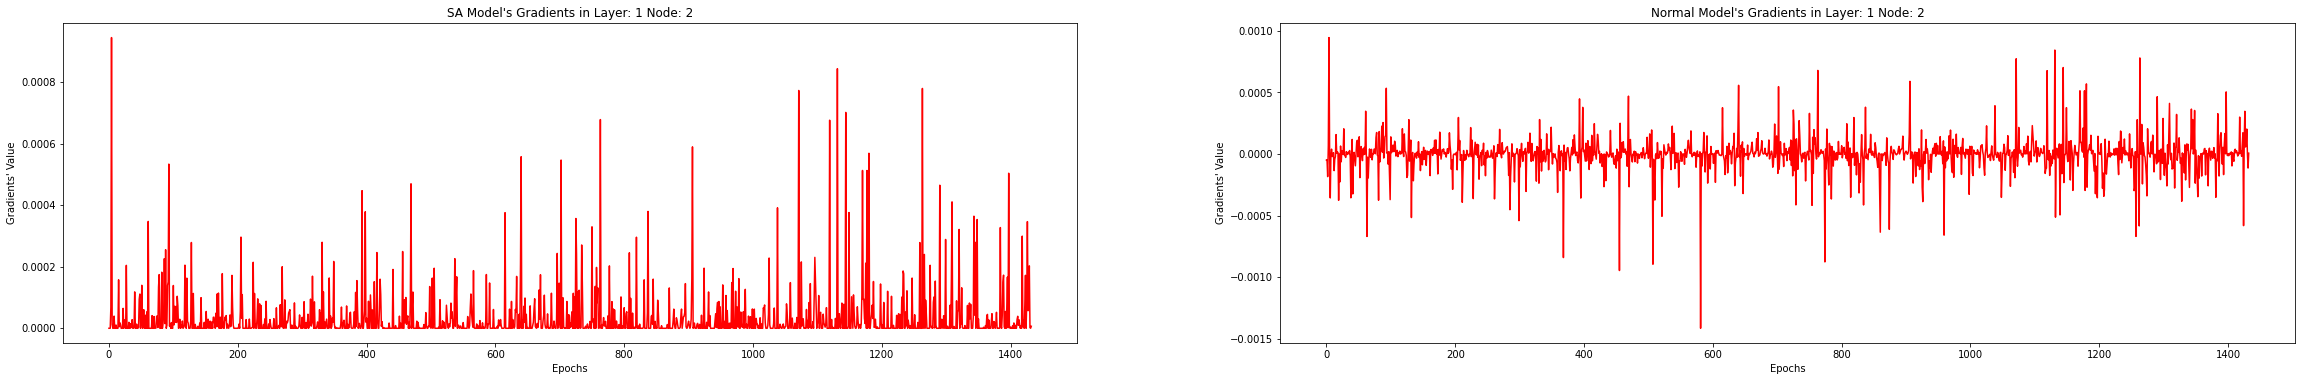

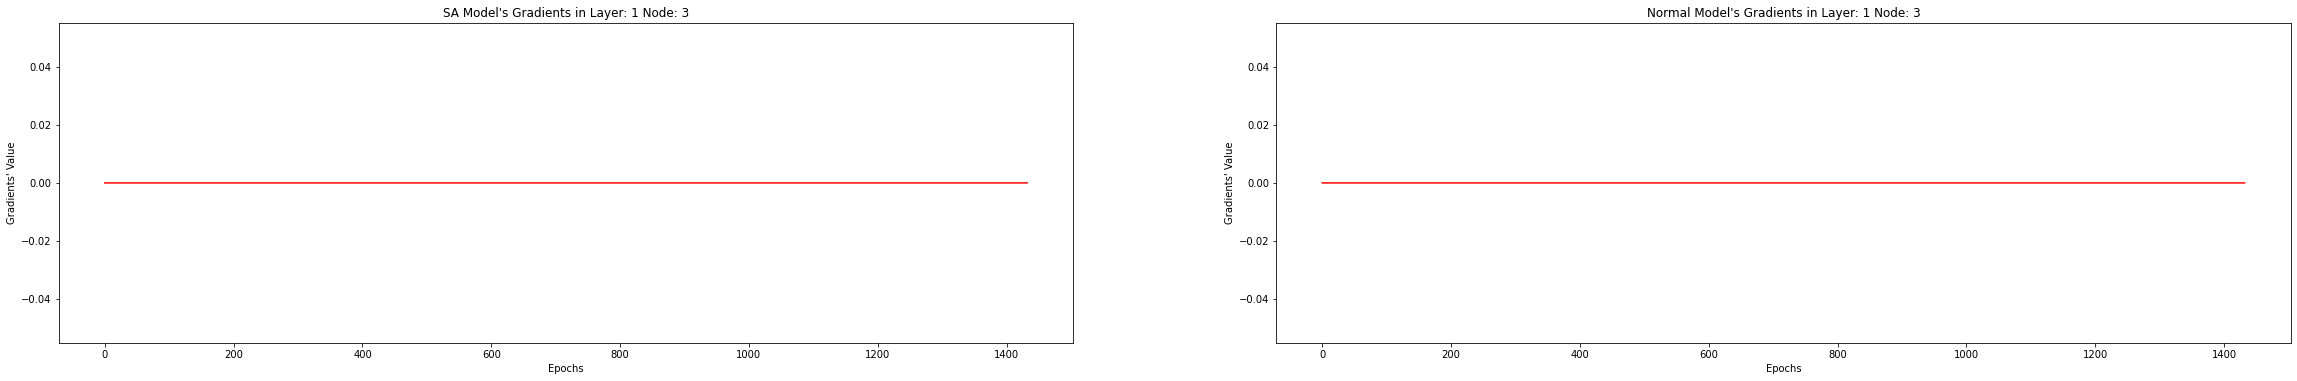

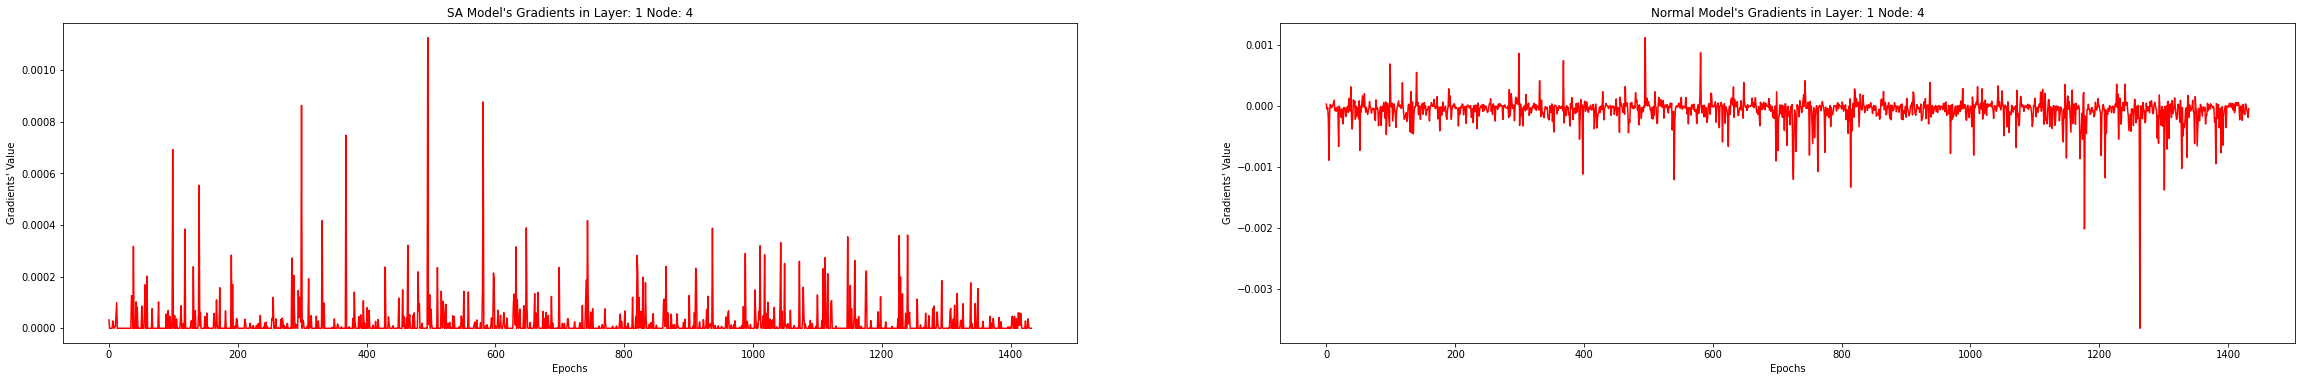

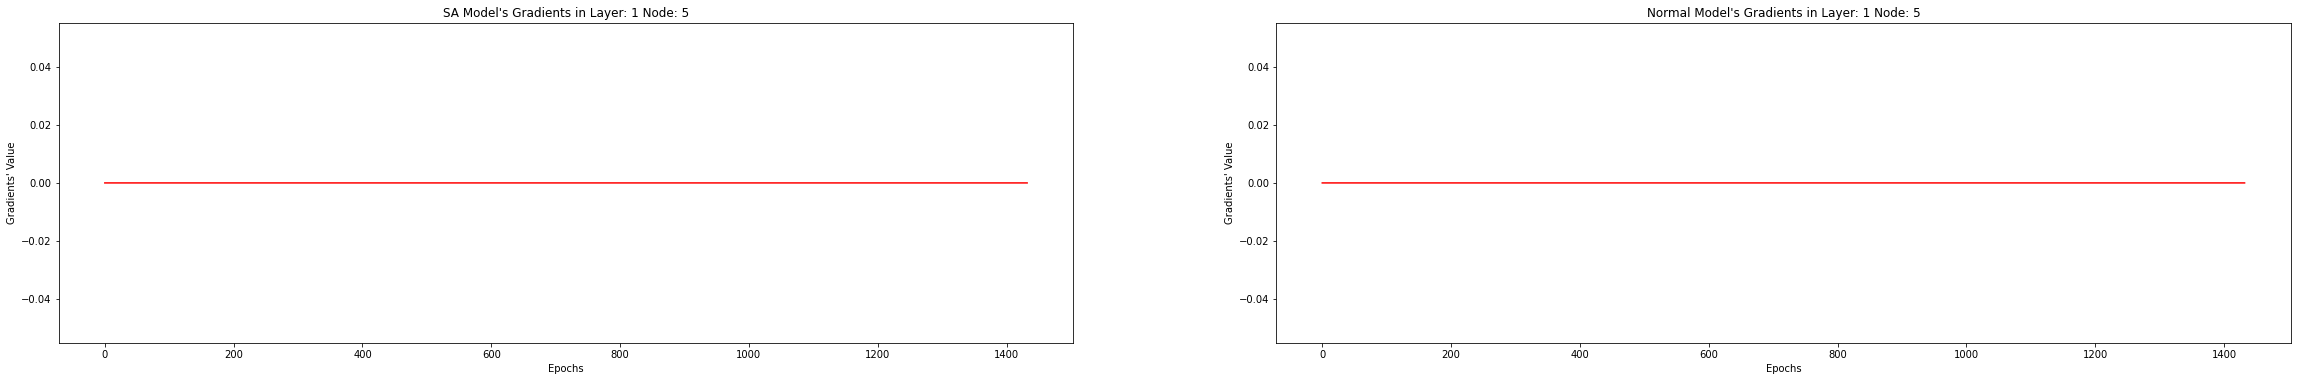

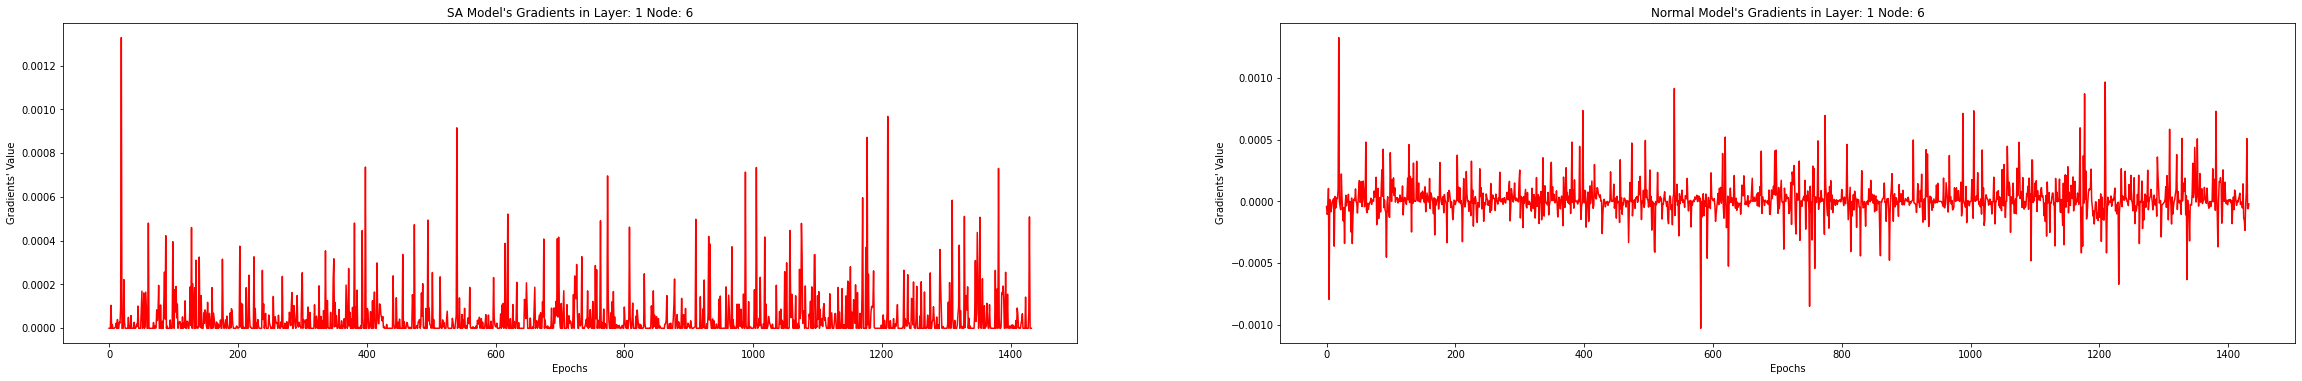

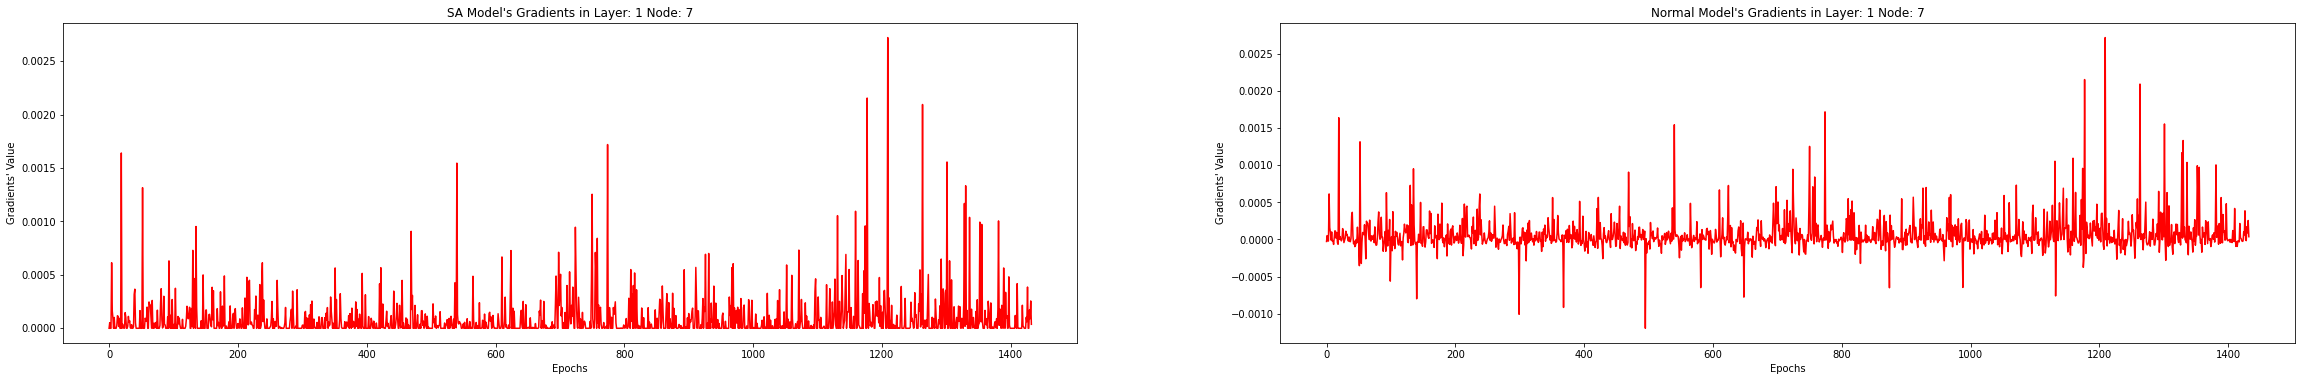

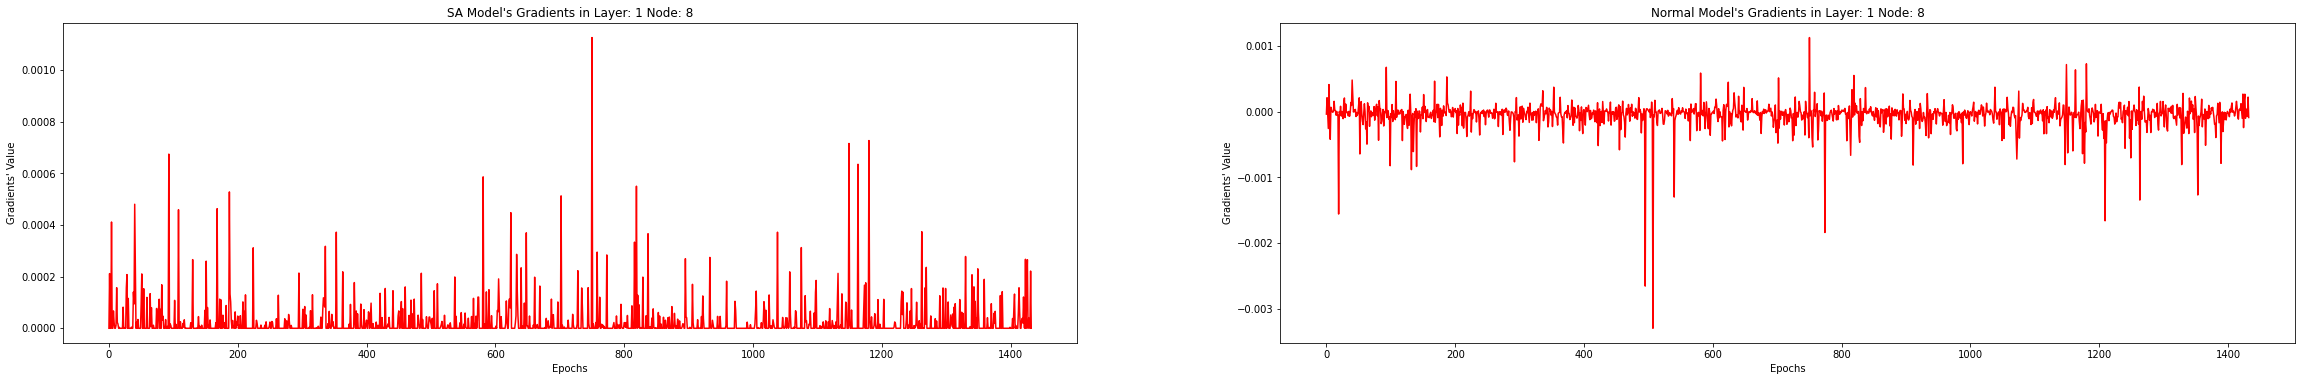

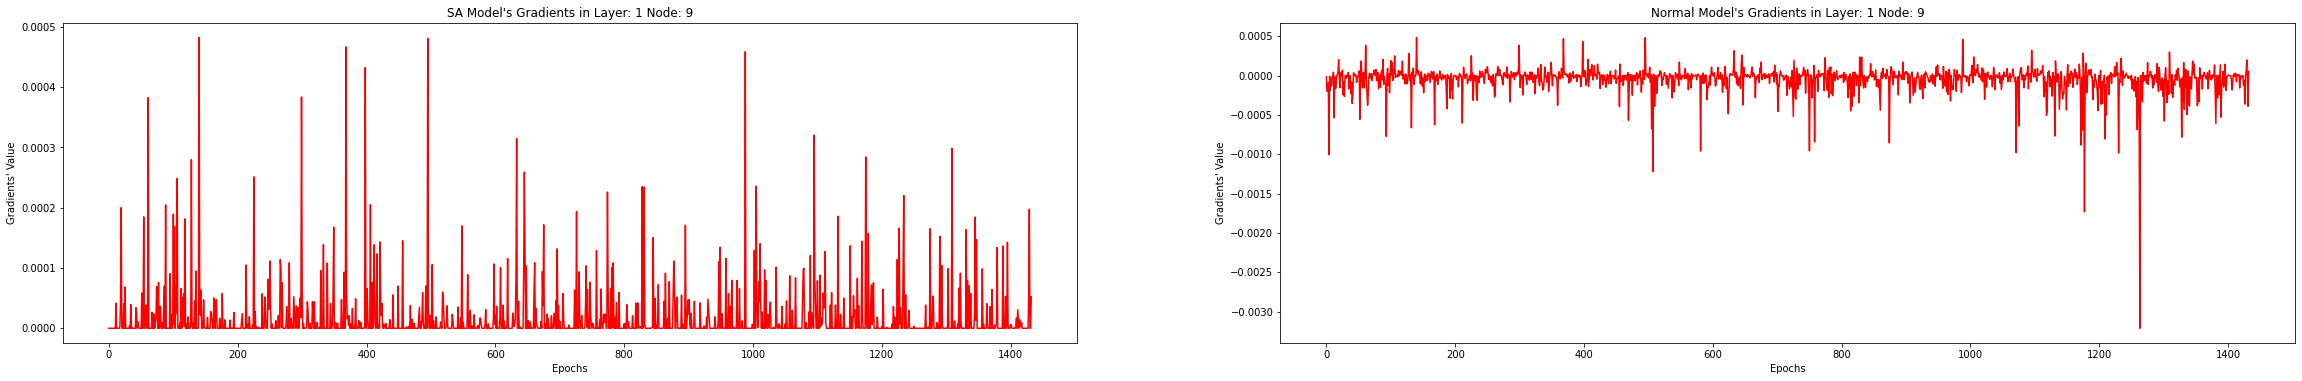

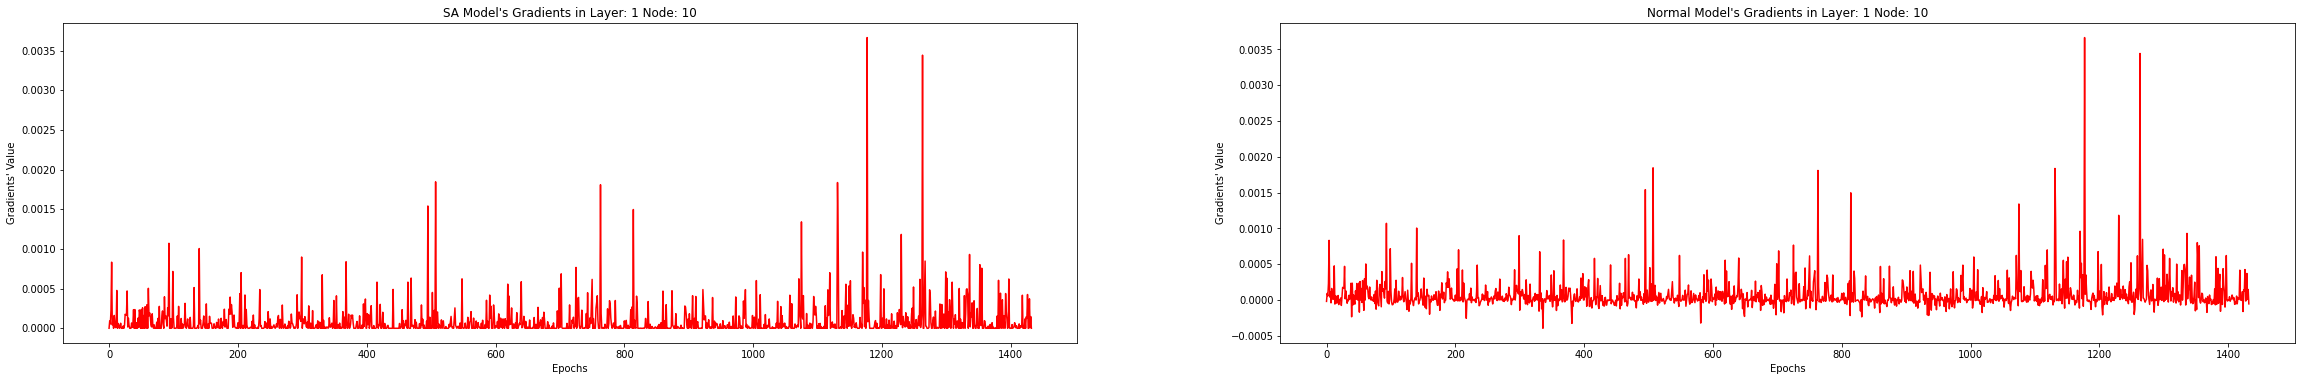

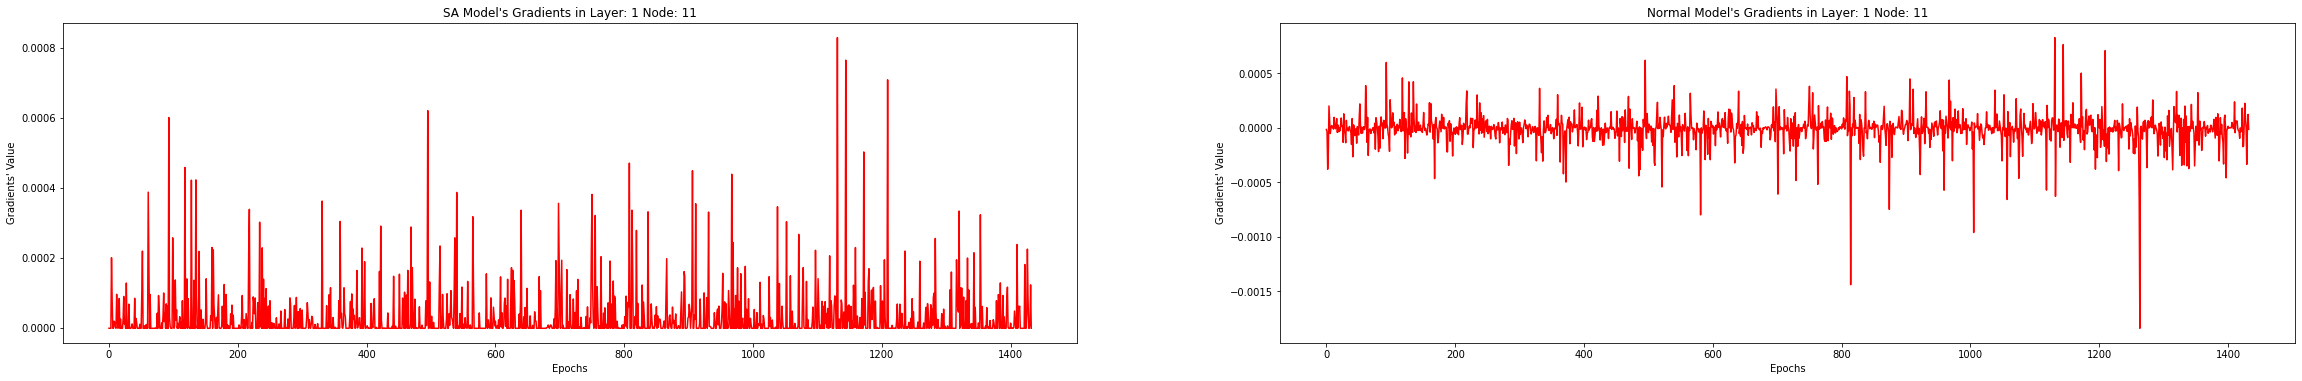

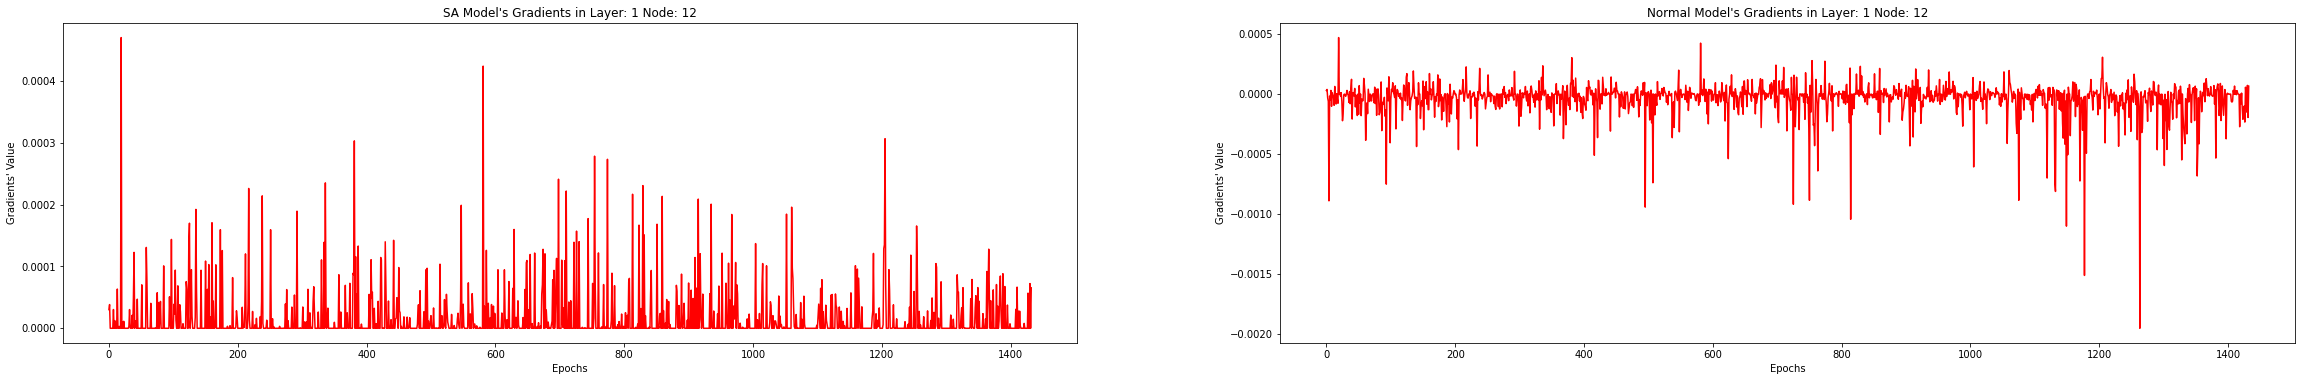

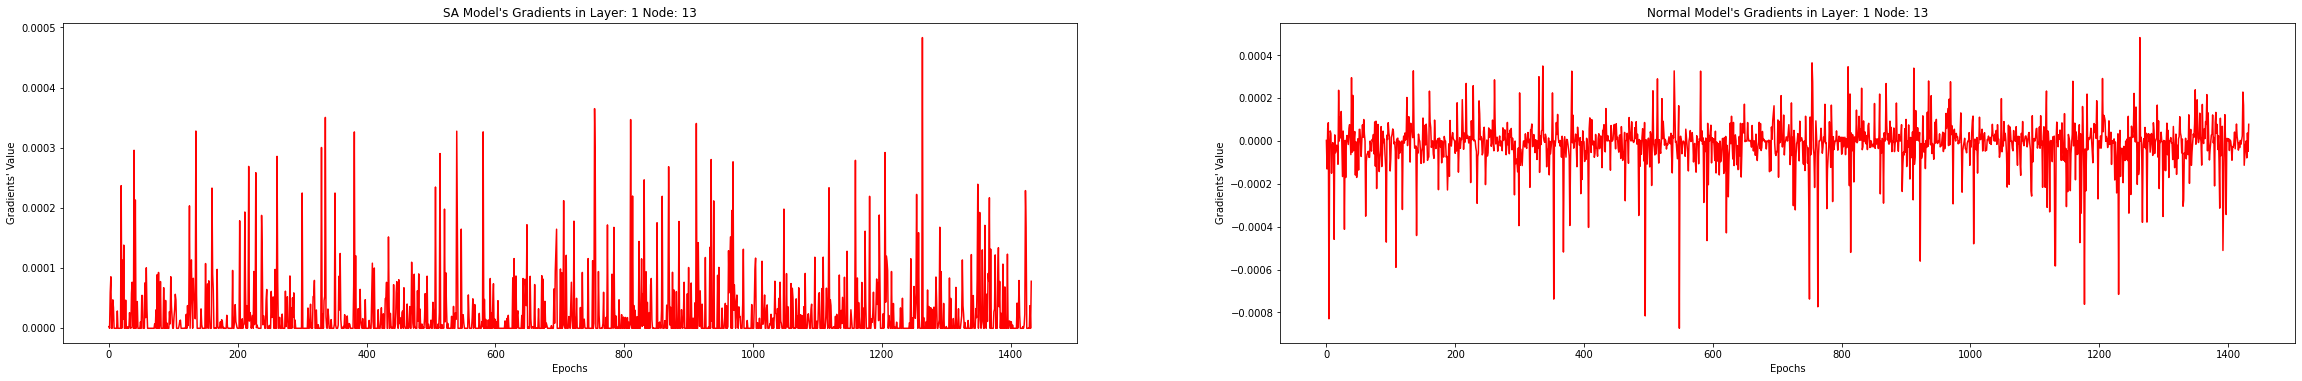

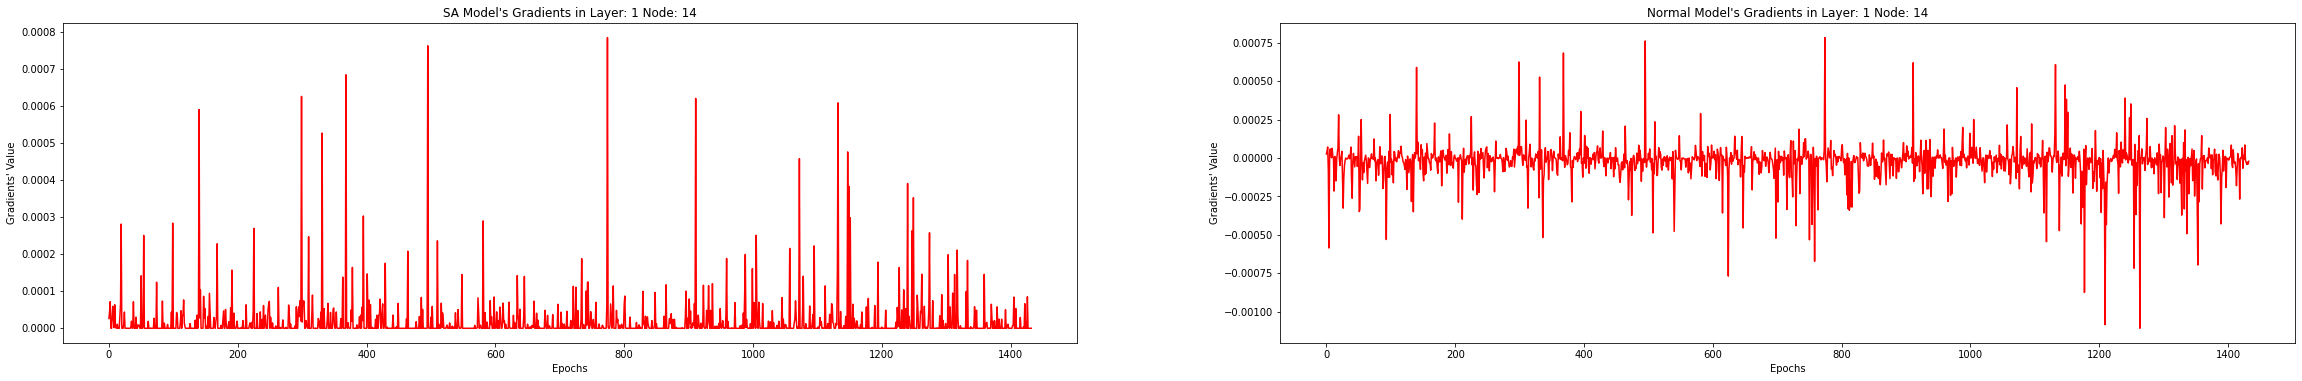

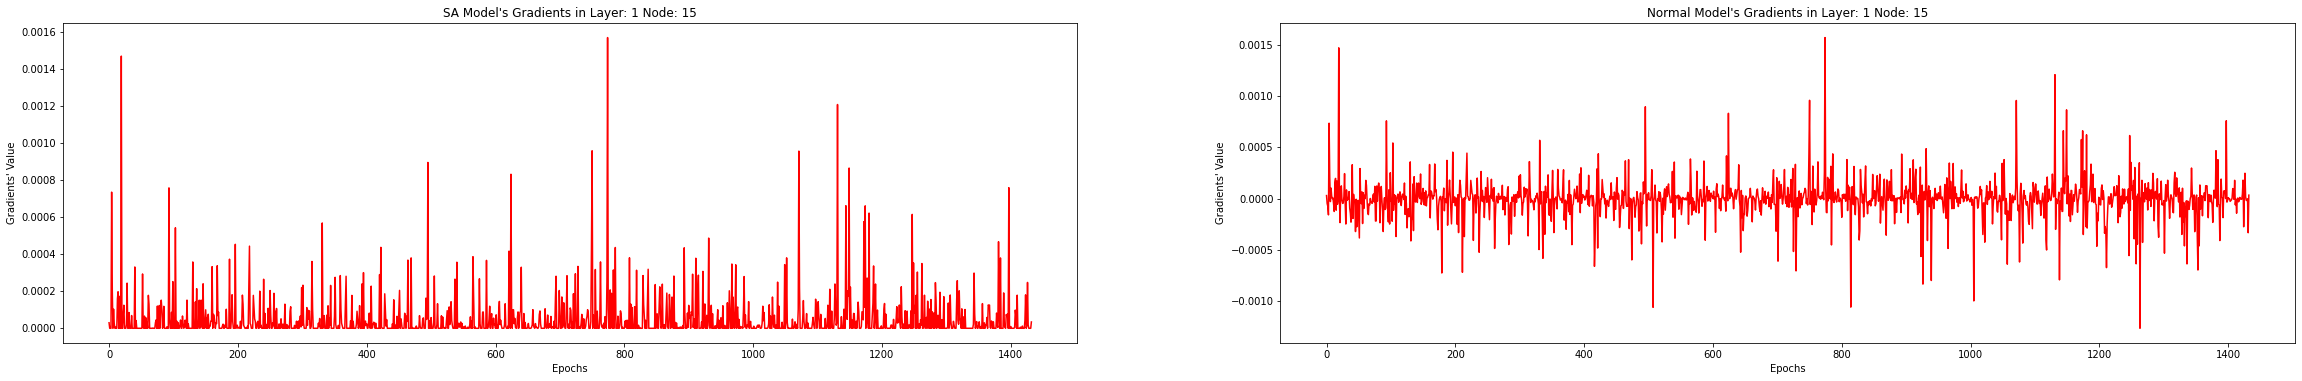

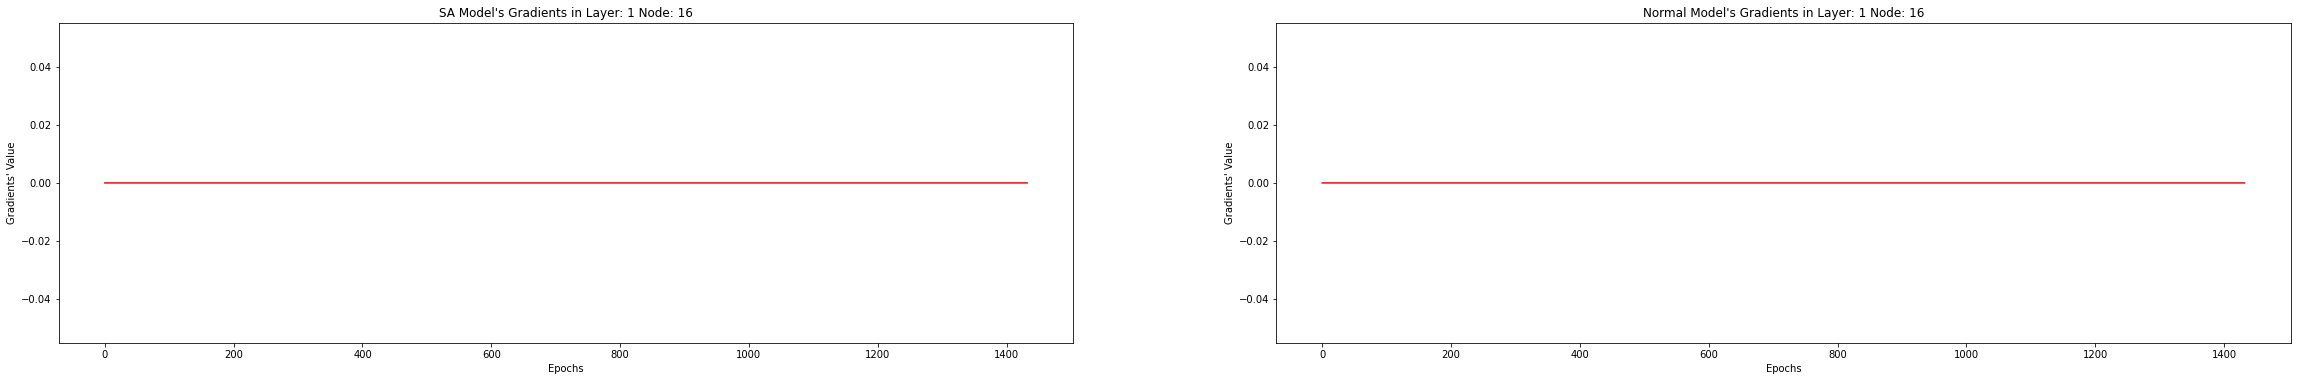

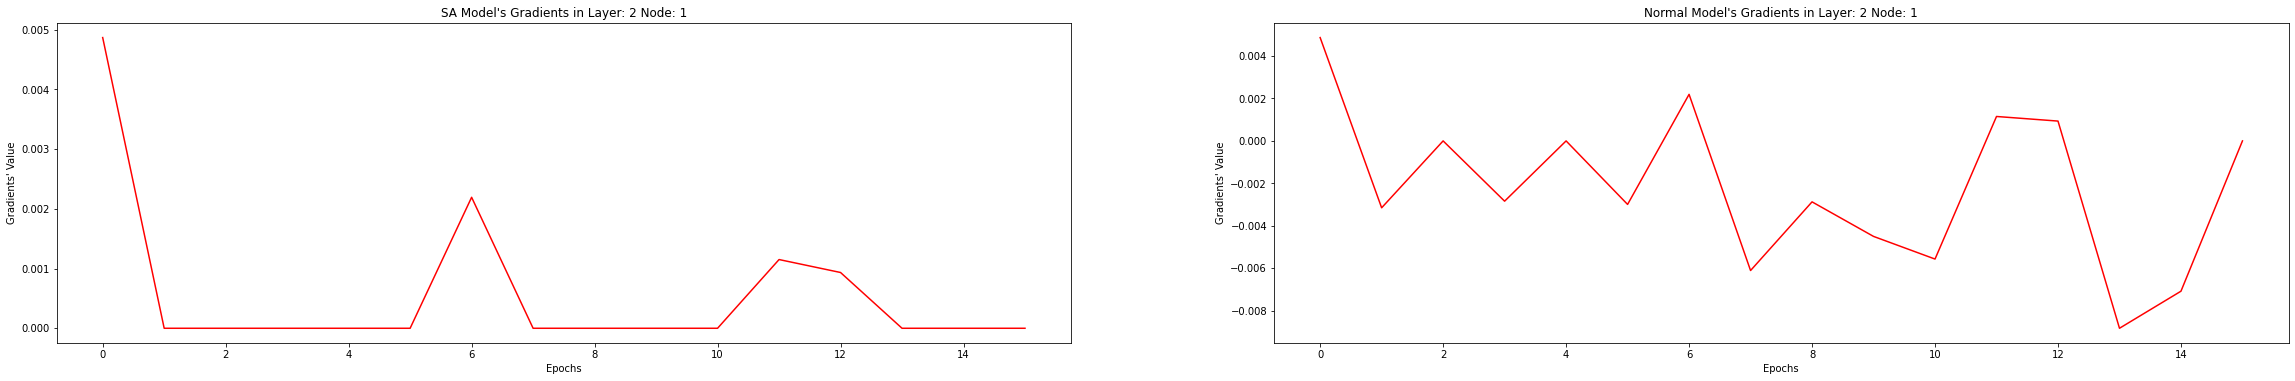

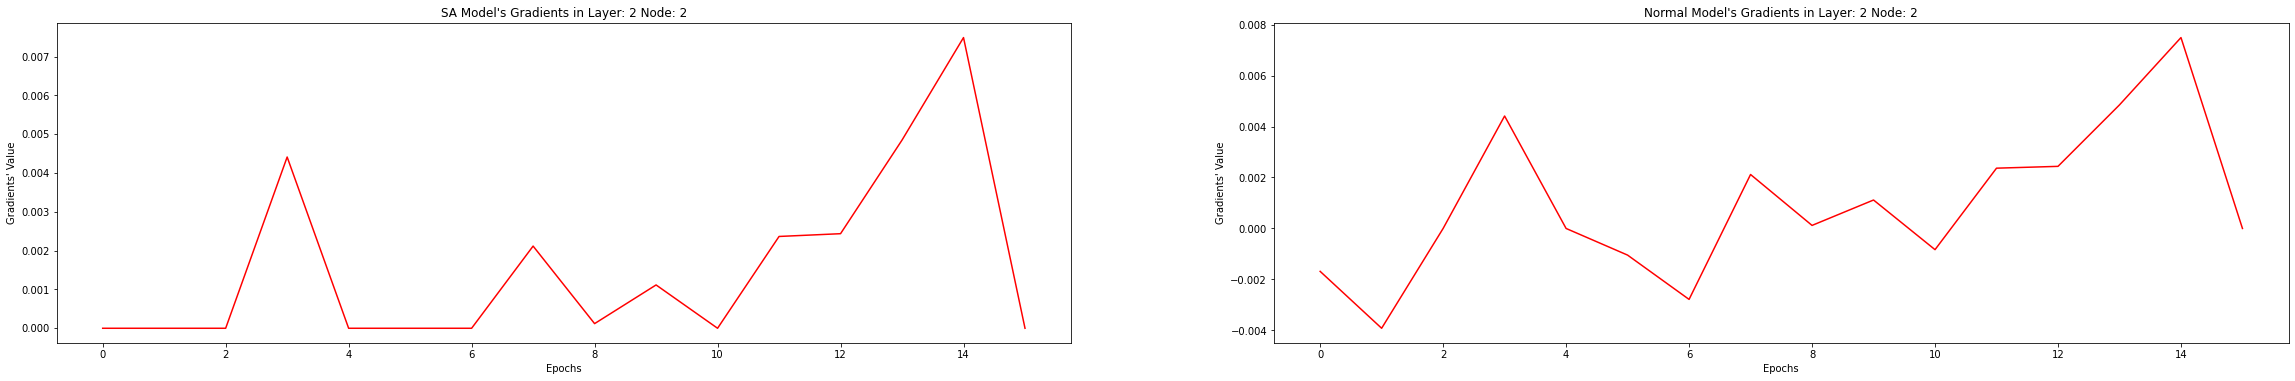

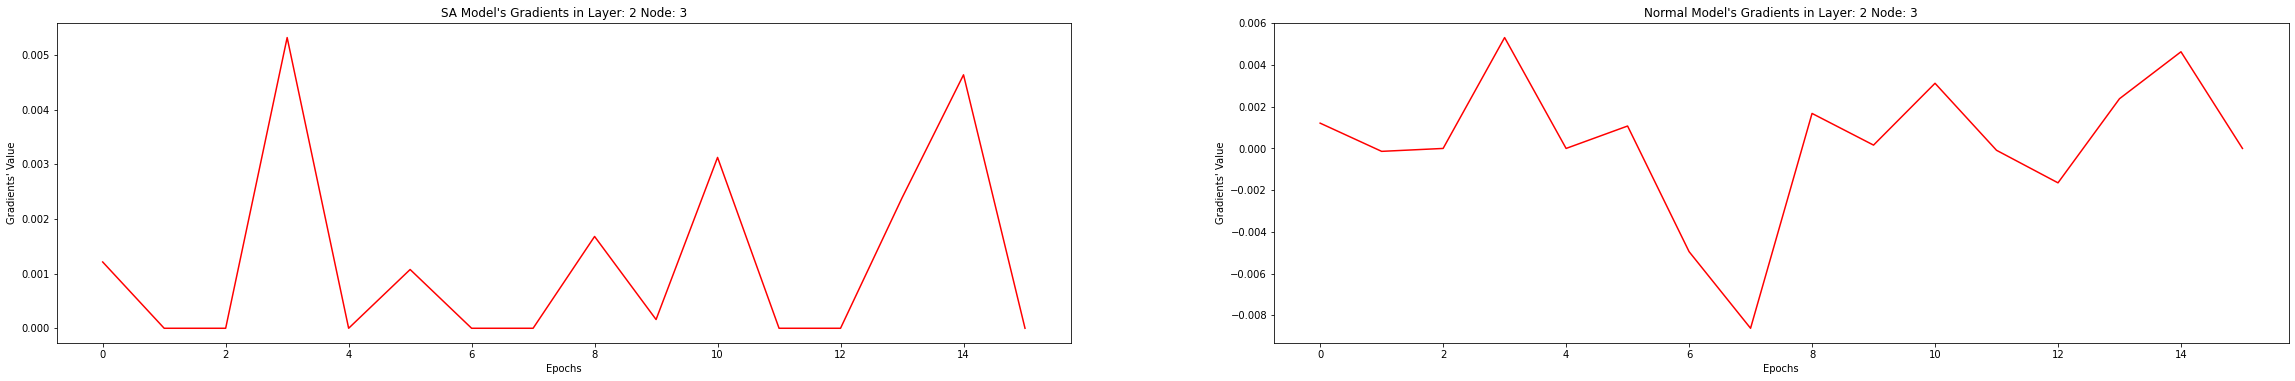

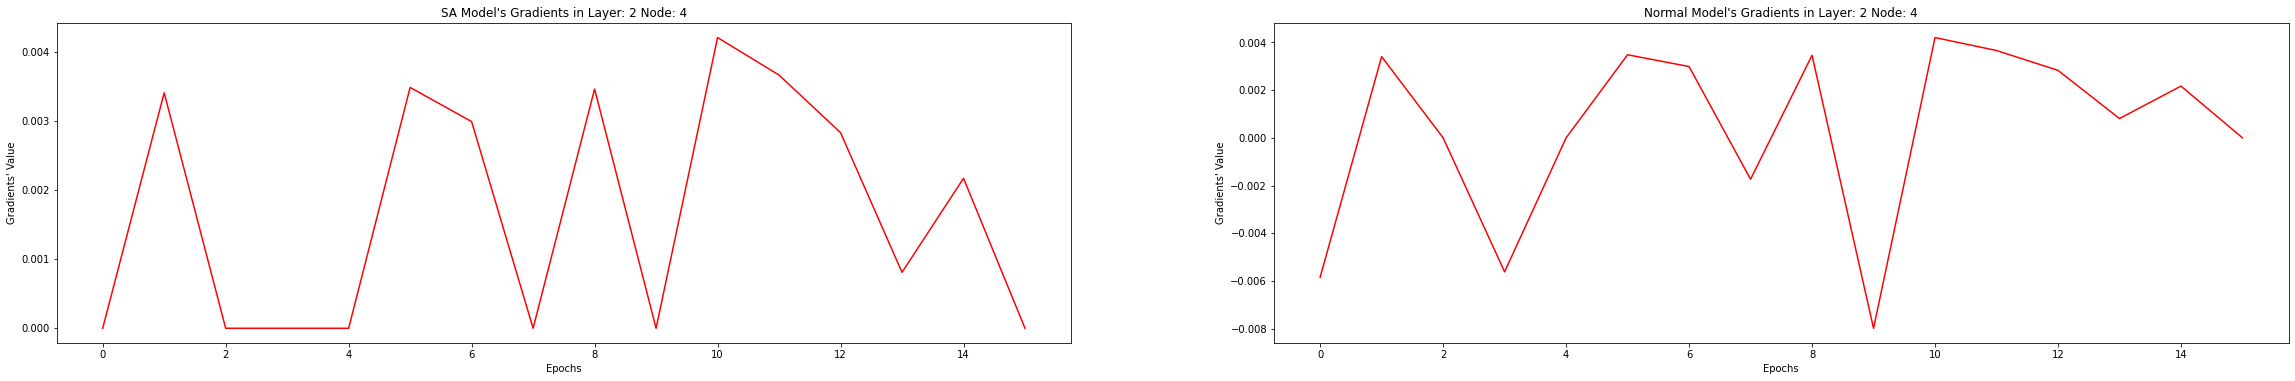

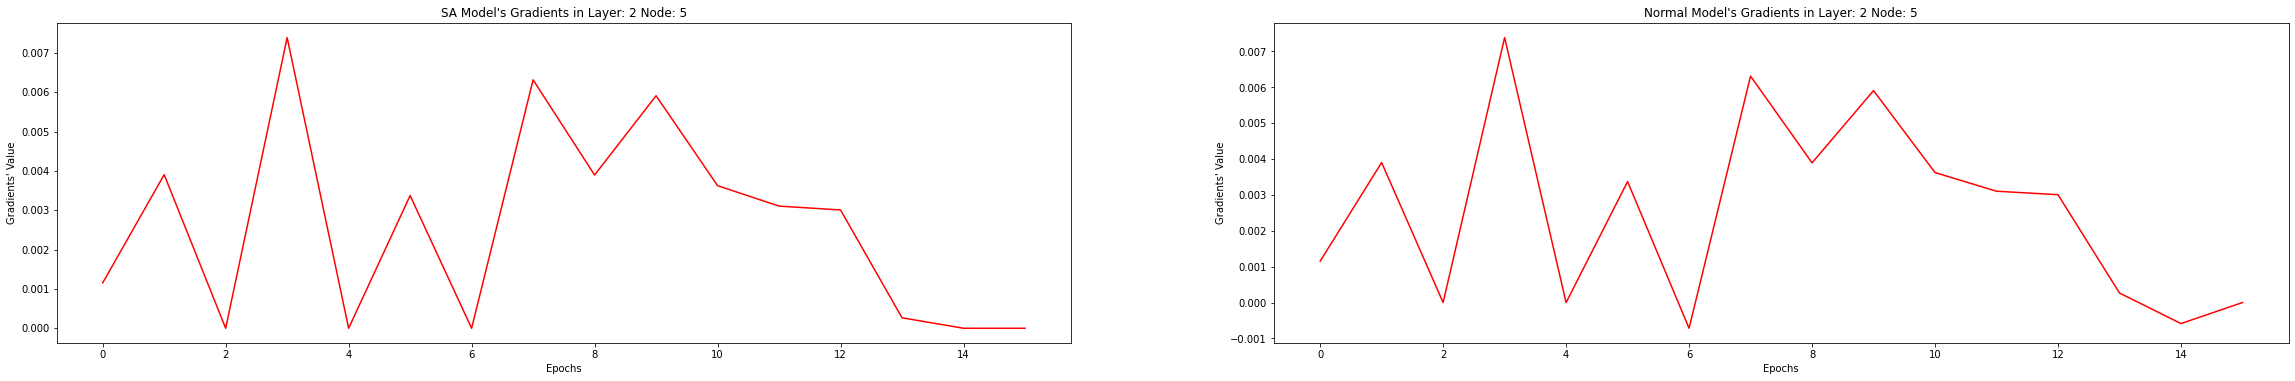

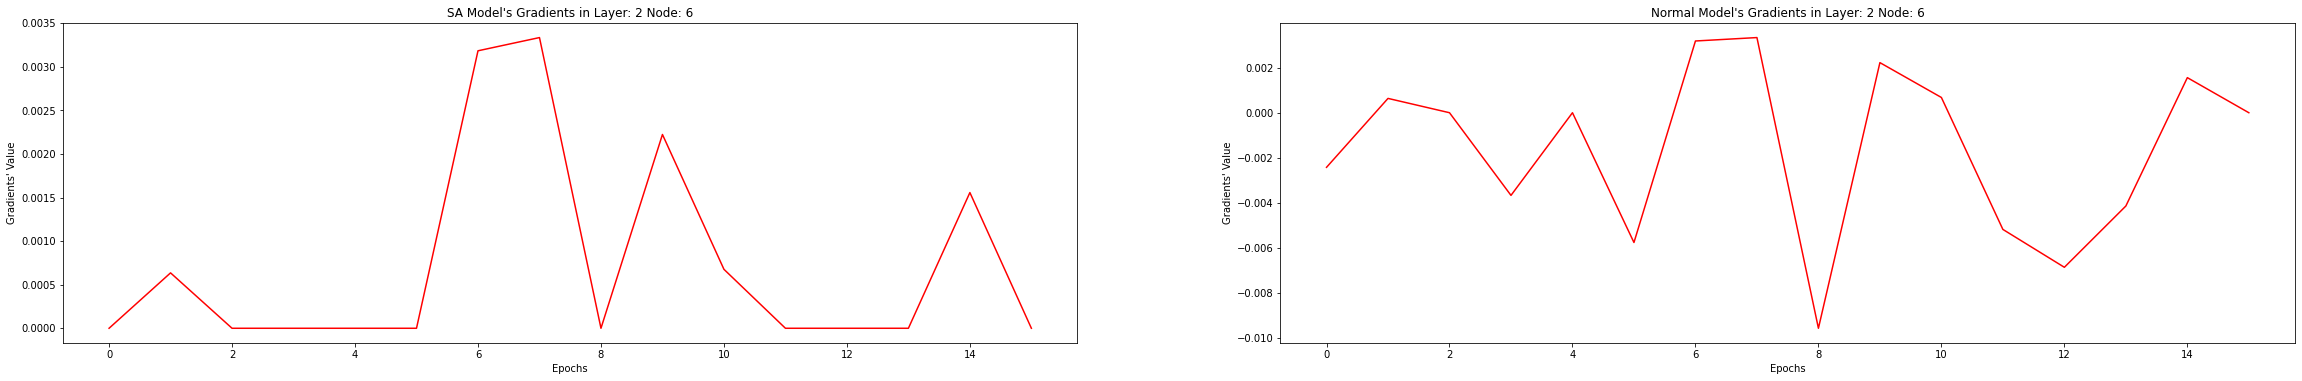

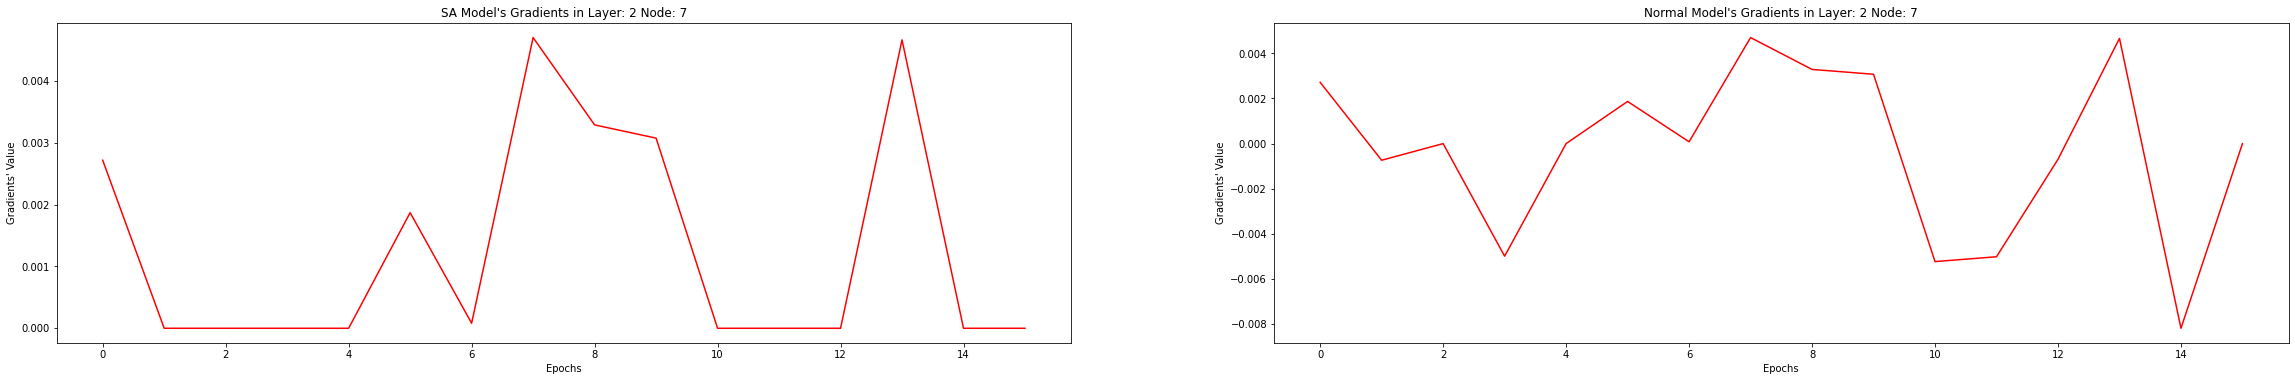

In [ ]:
SA_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, EPOCHS)

# **WEIGHT vectors and BIASSES**

In [ ]:
print(SA_model_GCN.conv1)
sd = SA_model_GCN.state_dict()
print(len(sd.items()))
whole_weights = sd.items()
#print(whole_weights)
print(colored('===========================================================================================================', 'red'))


#list(model_GCN.state_dict().items())[0][1].data[:]
#print(sd.get('conv1.bias'))
conv1_weights = sd.get('conv1.lin.weight')
conv1_biases = sd.get('conv1.bias')
conv2_weights = sd.get('conv2.lin.weight')
conv2_biases = sd.get('conv2.bias')
print(f'Length of CONV1_Weights: {len(conv1_weights)}')
print(f'Length of CONV1.Bias: {len(conv1_biases)}')
print(f'Length of CONV2_Weights: {len(conv2_weights)}')
print(f'Length of CONV2.Bias: {len(conv2_biases)}')
#print(f'CONV1_Weights: {conv1_weights}')
#print(f'CONV1.Bias: {conv1_biases}')
#print(f'CONV2_Weights: {conv2_weights}')
#print(f'CONV2.Bias: {conv2_biases}')

GCNConv(1433, 16)
4
Length of CONV1_Weights: 16
Length of CONV1.Bias: 16
Length of CONV2_Weights: 7
Length of CONV2.Bias: 7


In [ ]:
'''
def train_step():
  SA_model_GCN.train(True)
  SA_optimizer.zero_grad()  # Clear gradients.
  out_GCN = SA_model_GCN(data.x, data.edge_index)  # Perform a single forward pass.
  SA_loss = loss_calculations(out_GCN[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
  SA_loss.backward(retain_graph=True)  # Derive gradients.


  #old_gradients = torch.autograd.grad(SA_loss, SA_model_GCN.parameters())
  #SA_bias1, SA_layer1, SA_bias2, SA_layer2 = SA_backpropagation(old_gradients)
  

  #sd = SA_model_GCN.state_dict()
  #whole_weights = sd.items()

  #conv1_weights = sd.get('conv1.lin.weight')
  #conv1_biases = sd.get('conv1.bias')
  #conv2_weights = sd.get('conv2.lin.weight')
  #conv2_biases = sd.get('conv2.bias')
  before_square = []
  after_square = []

  for name, param in SA_model_GCN.named_parameters():
    if name == "conv1.bias":
      before_square.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_square.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_square.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_square.append(param.grad.detach().clone())
    if name == "conv2.bias":
      before_square.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_square.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_square.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_square.append(param.grad.detach().clone())
  
  non_SA_backpropagation_SAME_MODEL(before_square)  
  SA_backpropagation_SAME_MODEL(after_square)


  SA_optimizer.step()  # Update parameters based on gradients.
  


  return SA_loss
  '''